In [1]:
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from sklearn.model_selection  import cross_val_score
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import itertools

Cargamos de scores.csv los datos de los 22 pacientes a evaluar, quitando las columnas innecesarias

In [2]:
datosPacientes = pd.read_csv('depresjon-dataset/data/scores.csv', na_values='--undefined--')
datosPacientes = datosPacientes.drop(columns=['number'])
datosPacientes = datosPacientes.drop(columns=['days'])
datosPacientes.head()

,gender,age,afftype,inpatient,edu,marriage,work,madrs1,madrs2
0,2,35-39,2,2,6-10,1,2,19,19
1,2,40-44,1,2,6-10,2,2,24,11
2,1,45-49,2,2,6-10,2,2,24,25
3,2,25-29,2,2,11-15,1,1,20,16
4,2,50-54,2,2,11-15,2,2,26,26


Número pacientes por generó y su clase iniciales

In [3]:
print("Pacientes género masculino:", sum(datosPacientes.gender == 2))
print("Pacientes género femenino:", sum(datosPacientes.gender == 1))
print("Pacientes con depresión:", sum(datosPacientes.afftype == 2))
print("Pacientes bipolares:", sum(datosPacientes.afftype == 1))
print("Pacientes género masculino y depresión:", sum((datosPacientes.gender == 2) & (datosPacientes.afftype == 2)))
print("Pacientes género femenino y depresión:", sum((datosPacientes.gender == 1) & (datosPacientes.afftype == 2)))
print("Pacientes género masculino y bipolares:", sum((datosPacientes.gender == 2) & (datosPacientes.afftype == 1)))
print("Pacientes género femenino y bipolares:", sum((datosPacientes.gender == 1) & (datosPacientes.afftype == 1)))

Pacientes género masculino: 12
Pacientes género femenino: 10
Pacientes con depresión: 15
Pacientes bipolares: 7
Pacientes género masculino y depresión: 8
Pacientes género femenino y depresión: 7
Pacientes género masculino y bipolares: 4
Pacientes género femenino y bipolares: 3


Seleccionamos por generos los pacientes tanto depresivos como bipolares para distribuir los datos con el mismo
número de pacientes de cada tipo y género.

In [4]:
index_type1_male = datosPacientes[(datosPacientes.afftype==1) & (datosPacientes.gender==2)] 
index_type1_female = datosPacientes[(datosPacientes.afftype==1) & (datosPacientes.gender==1)]
index_type2_male = datosPacientes[(datosPacientes.afftype==2) & (datosPacientes.gender==2)]
index_type2_female = datosPacientes[(datosPacientes.afftype==2) & (datosPacientes.gender==1)]

remuve_n = 0

if(len(index_type1_male) <= len(index_type2_male)):
    remove_male = len(index_type2_male) - len(index_type1_male)
    index_type2_male = index_type2_male.sample(len(index_type1_male))   
else:
    remove_male = len(index_type1_male) - len(index_type2_male)
    index_type1_male = index_type1_male.sample(len(index_type2_male))
if(len(index_type1_female) <= len(index_type2_female)):
    remove_female = len(index_type2_female) - len(index_type1_female)
    index_type2_female = index_type2_female.sample(len(index_type1_female))
else:
    remove_female = len(index_type1_female) - len(index_type2_female)
    index_type1_female = index_type1_female.sample(len(index_type2_female))
    
remove_n = remove_male + remove_female

In [5]:
datosPacientes = pd.concat([index_type1_male, index_type1_female])
datosPacientes = pd.concat([datosPacientes, index_type2_male])
datosPacientes = pd.concat([datosPacientes, index_type2_female])
datosPacientes.head()

,gender,age,afftype,inpatient,edu,marriage,work,madrs1,madrs2
1,2,40-44,1,2,6-10,2,2,24,11
8,2,45-49,1,2,6-10,1,2,26,26
11,2,40-44,1,2,6-10,2,2,25,21
12,2,35-39,1,2,11-15,2,2,18,13
6,1,20-24,1,2,11-15,2,1,24,25


Número pacientes por generó y su clase tras la distribución de los datos

In [6]:
print("Pacientes género masculino:", sum(datosPacientes.gender == 2))
print("Pacientes género femenino:", sum(datosPacientes.gender == 1))
print("Pacientes con depresión:", sum(datosPacientes.afftype == 2))
print("Pacientes bipolares:", sum(datosPacientes.afftype == 1))
print("Pacientes género masculino y depresión:", sum((datosPacientes.gender == 2) & (datosPacientes.afftype == 2)))
print("Pacientes género femenino y depresión:", sum((datosPacientes.gender == 1) & (datosPacientes.afftype == 2)))
print("Pacientes género masculino y bipolares:", sum((datosPacientes.gender == 2) & (datosPacientes.afftype == 1)))
print("Pacientes género femenino y bipolares:", sum((datosPacientes.gender == 1) & (datosPacientes.afftype == 1)))

Pacientes género masculino: 8
Pacientes género femenino: 6
Pacientes con depresión: 7
Pacientes bipolares: 7
Pacientes género masculino y depresión: 4
Pacientes género femenino y depresión: 3
Pacientes género masculino y bipolares: 4
Pacientes género femenino y bipolares: 3


Cargamos de la carpeta condition los datos de los archivos CSV de actividad correspondiente a cada paciente que hemos seleccionado, almacenandolo en un array

In [7]:
actividadPaciente = []
for i in list(datosPacientes.index):
    path = 'depresjon-dataset/data/condition/condition_' + str(i+1) + '.csv'
    actividadPaciente.append(pd.read_csv(path, na_values='--undefined--'))
datosPacientes = datosPacientes.reset_index(drop=True)

Eliminamos la columna date

In [8]:
for i in range(0, 22 - remove_n):
    actividadPaciente[i] = actividadPaciente[i].drop(columns=['date'])

Seleccionamos el número de horas por las que vamos a agregar los datos de actividad medidos en cada paciente

In [9]:
#np.random.seed(10)
#remove_n = 8
#drop_indices = np.random.choice(datosPacientes[datosPacientes['afftype'] == 2].index, remove_n, replace=False)
#datosPacientes = datosPacientes.drop(drop_indices).reset_index(drop=True)
#datosPacientes = datosPacientes.groupby('gender')
#datosPacientes.apply(lambda x: x.sample(datosPacientes.size().min()))
hours = 6
resample_hour = '6H'
n_hour_class = int(24 / hours)

Realizamos la agregación cada resample_hour horas para calcular la media (meanActivity), suma (sumActivity), desviación típica (stdActivity), varianza (varActivity), maximo (max) y minimo (min) de la actividad de cada paciente.

In [10]:
for i in range(0, 22 - remove_n):
    actividadPaciente[i].index = pd.DatetimeIndex(actividadPaciente[i].timestamp)
    aux = actividadPaciente.copy()
    actividadPaciente[i] = round(aux[i].resample(resample_hour).mean(),2)
    actividadPaciente[i]['sumActivity'] = round(aux[i].resample(resample_hour).sum(),2)
    actividadPaciente[i]['stdActivity'] = round(aux[i].resample(resample_hour).std()['activity'],2)
    actividadPaciente[i]['varActivity'] = round(aux[i].resample(resample_hour).var()['activity'],2)
    actividadPaciente[i]['max'] = aux[i].resample(resample_hour).max()['activity']
    actividadPaciente[i]['min'] = aux[i].resample(resample_hour).min()['activity']
    actividadPaciente[i]=actividadPaciente[i].rename(columns = {'activity':'meanActivity'})

Para evitar incluir en los datos de actividad de cada paciente periodos al final donde la monitorización habia acabado y hay registros de actividad a 0, realizamos la siguiente operación para conseguir disminuir su porcentaje:
Mientras que la suma de la actividad media del 20 % del final de los datos sea menor que la suma de la actividad media del 20 % del principio de los datos entre 3, vamos disminuyendo los datos un 5 % del final.

In [11]:
for j in range(0,22 - remove_n):
    while(sum(actividadPaciente[j].meanActivity[math.trunc(len(actividadPaciente[j])*0.80):]) < sum(actividadPaciente[j].meanActivity[:math.trunc((len(actividadPaciente[j])*0.20)/3)])):
        actividadPaciente[j] = actividadPaciente[j][:math.trunc(len(actividadPaciente[j])*0.95)]

Eliminamos las primeras horas hasta el primer registro que comience a las 00:00:00

In [12]:
i = 0
while(i < len(actividadPaciente)):
    while(actividadPaciente[i].index[0].hour != 0):
        actividadPaciente[i] = actividadPaciente[i][1:]
    i = i + 1

Repetimos el proceso eliminando ahora las últimas horas hasta el primer registro anterior a las 00:00:00

In [13]:
i = 0
limitHour = max(actividadPaciente[0].index.hour.values)
while(i < len(actividadPaciente)):
    while(actividadPaciente[i].index[-1].hour != limitHour):
        actividadPaciente[i] = actividadPaciente[i][:-1]
    i = i + 1

Dejamos en la columna hour solamente la hora correspondiente al periodo de actividad

In [14]:
for i in range(0, 22 - remove_n):
    actividadPaciente[i]['hour'] = actividadPaciente[i].index
    actividadPaciente[i].hour = actividadPaciente[i].hour.astype(str).tolist()
    actividadPaciente[i] = actividadPaciente[i].reset_index(drop=True)

In [15]:
for i in range(0, 22 - remove_n):
    times = []
    for elem in actividadPaciente[i].hour:
        times.append(elem.split(' ')[1])
    actividadPaciente[i].hour = times

En las siguientes graficas podemos ver el nivel de actividad por cada uno de los campos obtenidos para cada paciente

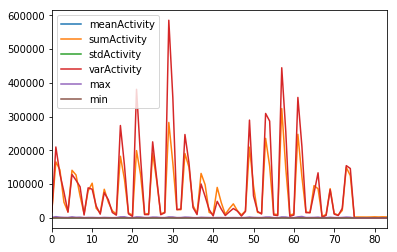

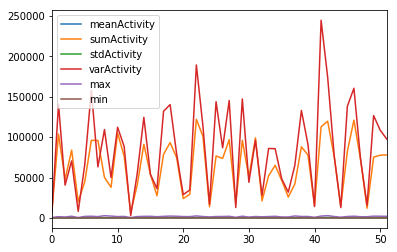

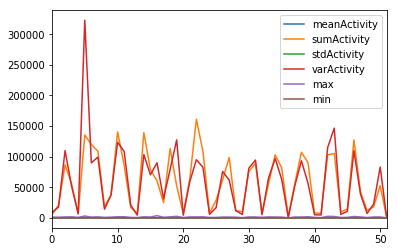

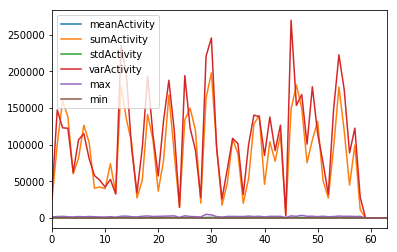

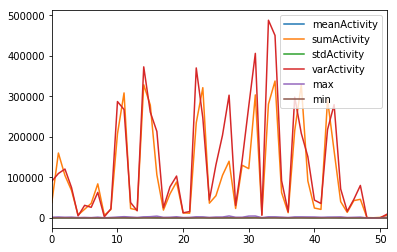

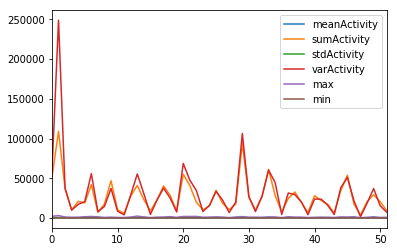

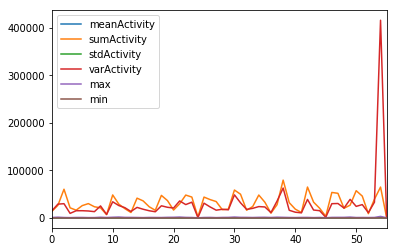

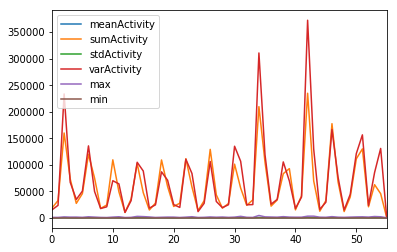

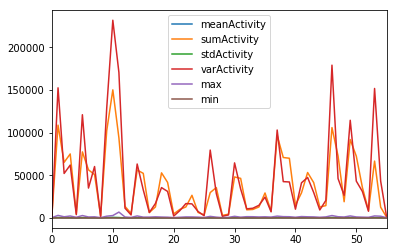

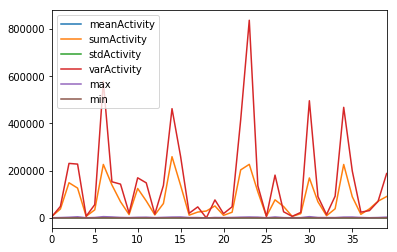

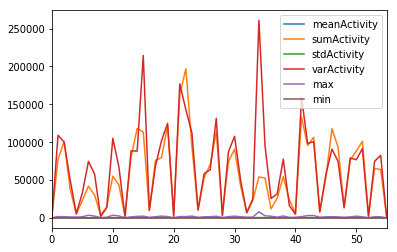

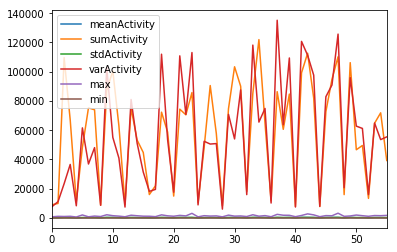

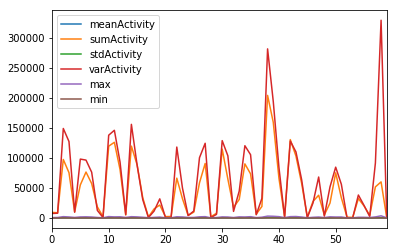

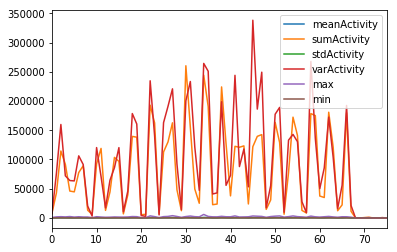

In [16]:
for i in range(0, 22 - remove_n):
    actividadPaciente[i].plot()

Concatenamos los dataframes para que cada paciente tenga su correspondiente tabla de actividad

In [17]:
finalDF = pd.DataFrame()
for i in range(0, 22 - remove_n):
    df1 = actividadPaciente[i]
    df2 = datosPacientes[i:i+1].reindex(datosPacientes[i:i+1].index.repeat(len(actividadPaciente[i]))).reset_index(drop=True)
    auxDF = pd.concat([df1,df2], axis=1)
    finalDF = pd.concat([finalDF,auxDF]).reset_index(drop=True)

Normalizamos todas las columnas

In [18]:
le = preprocessing.LabelEncoder()
finalDF.age = le.fit_transform(finalDF.age)
finalDF.edu = le.fit_transform(finalDF.edu)
finalDF.hour = le.fit_transform(finalDF.hour)
finalDF = finalDF[~finalDF['stdActivity'].isnull()]
X_activity = finalDF.drop(['afftype'], axis=1)
scaler = MinMaxScaler()

X_activity.meanActivity = scaler.fit_transform(np.expand_dims(X_activity.meanActivity, axis=1))
X_activity.stdActivity = scaler.fit_transform(np.expand_dims(X_activity.stdActivity, axis=1))
X_activity.madrs1 = scaler.fit_transform(np.expand_dims(X_activity.madrs1, axis=1))
X_activity.madrs2 = scaler.fit_transform(np.expand_dims(X_activity.madrs2, axis=1))
X_activity.varActivity = scaler.fit_transform(np.expand_dims(X_activity.varActivity, axis=1))
X_activity.sumActivity = scaler.fit_transform(np.expand_dims(X_activity.sumActivity, axis=1))
X_activity['max'] = scaler.fit_transform(np.expand_dims(X_activity['max'], axis=1))
X_activity['min'] = scaler.fit_transform(np.expand_dims(X_activity['min'], axis=1))
y_activity = finalDF.afftype

C:\Users\ismaelsetti\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ismaelsetti\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ismaelsetti\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ismaelsetti\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\ismaelsetti\AppData

In [19]:
X_activity.head()

,meanActivity,sumActivity,stdActivity,varActivity,max,min,hour,gender,age,inpatient,edu,marriage,work,madrs1,madrs2
0,0.056345,0.056347,0.146833,0.021559,0.189375,0.037037,0,2,4,2,2,2,2,0.666667,0.0
1,0.490744,0.490746,0.500885,0.250881,0.467000,0.049383,1,2,4,2,2,2,2,0.666667,0.0
2,0.421696,0.421699,0.394379,0.155537,0.275625,0.049383,2,2,4,2,2,2,2,0.666667,0.0
3,0.138043,0.138043,0.303789,0.092287,0.189375,0.037037,3,2,4,2,2,2,2,0.666667,0.0
4,0.053499,0.053499,0.142920,0.020427,0.167000,0.037037,0,2,4,2,2,2,2,0.666667,0.0


Eliminamos las columnas que hacen referencia a los datos del paciente y que no tienen relacion con la actividad

In [20]:
gender = X_activity.gender[X_activity.hour==0].reset_index(drop=True)
age = X_activity.age[X_activity.hour==0].reset_index(drop=True)
inpatient = X_activity.inpatient[X_activity.hour==0].reset_index(drop=True)
edu = X_activity.edu[X_activity.hour==0].reset_index(drop=True)
marriage = X_activity.marriage[X_activity.hour==0].reset_index(drop=True)
work = X_activity.work[X_activity.hour==0].reset_index(drop=True)
madrs1 = X_activity.madrs1[X_activity.hour==0].reset_index(drop=True)
madrs2 = X_activity.madrs2[X_activity.hour==0].reset_index(drop=True)

X_activity = X_activity.drop(['gender'], axis=1)
X_activity = X_activity.drop(['age'], axis=1)
X_activity = X_activity.drop(['inpatient'], axis=1)
X_activity = X_activity.drop(['edu'], axis=1)
X_activity = X_activity.drop(['marriage'], axis=1)
X_activity = X_activity.drop(['work'], axis=1)
X_activity = X_activity.drop(['madrs1'], axis=1)
X_activity = X_activity.drop(['madrs2'], axis=1)

Graficas de días completos pacientes depresivos (Realizar con agregaciónes de 1 hora)

In [21]:
#X_activity[y_activity==2][:23].drop(columns=['hour','sumActivity', 'max', 'min', 'varActivity','stdActivity']).reset_index(drop=True).plot(ylim=[0, 0.35])
#X_activity[y_activity==2][24:47].drop(columns=['hour', 'sumActivity', 'max', 'min', 'varActivity','stdActivity']).reset_index(drop=True).plot(ylim=[0, 0.35])
#X_activity[y_activity==2][48:71].drop(columns=['hour', 'sumActivity', 'max', 'min', 'varActivity','stdActivity']).reset_index(drop=True).plot(ylim=[0, 0.35])
#X_activity[y_activity==2][72:95].drop(columns=['hour', 'sumActivity', 'max', 'min', 'varActivity','stdActivity']).reset_index(drop=True).plot(ylim=[0, 0.35])

Graficas de días completos pacientes bipolares (Realizar con agregaciónes de 1 hora)

In [22]:
#X_activity[y_activity==1][:23].drop(columns=['hour', 'sumActivity', 'max', 'min', 'varActivity','stdActivity']).plot(ylim=[0, 0.35])
#X_activity[y_activity==1][24:47].drop(columns=['hour', 'sumActivity', 'max', 'min', 'varActivity', 'stdActivity']).reset_index(drop=True).plot(ylim=[0, 0.35])
#X_activity[y_activity==1][48:71].drop(columns=['hour', 'sumActivity', 'max', 'min', 'varActivity','stdActivity']).reset_index(drop=True).plot(ylim=[0, 0.35])
#X_activity[y_activity==1][72:95].drop(columns=['hour', 'sumActivity', 'max', 'min', 'varActivity','stdActivity']).reset_index(drop=True).plot(ylim=[0, 0.35])

Ponemos las filas correspondientes a un mismo día en columnas, para que cada fila represente un día entero de actividad de los pacientes, enumerandolas según el número de particiones que hagamos.

In [23]:
columns = X_activity.drop(['hour'], axis=1).columns.values
X_activity_list = []
X_activity_final = X_activity[X_activity.hour==0].drop(['hour'], axis=1).reset_index(drop=True)
y_activity_final = y_activity[X_activity.hour==0].reset_index(drop=True)
X_activity_list.append(X_activity_final)
for i in range(0, n_hour_class - 1):
    X_activity_list.append(X_activity[X_activity.hour==i + 1].reset_index(drop=True))
    X_activity_list[-1] = X_activity_list[-1].drop(['hour'], axis=1)

for j in range(0, n_hour_class - 1):
    X_activity_list[j+1].columns = list(columns + str(j + 1))
    X_activity_final = pd.concat([X_activity_final, X_activity_list[j+1]], axis=1)

Añadimos las columnas con información referida a los pacientes que deseemos.

In [24]:
X_activity_final = pd.concat([X_activity_final, gender], axis=1)
#X_activity_final = pd.concat([X_activity_final, age], axis=1)
#X_activity_final = pd.concat([X_activity_final, inpatient], axis=1)
#X_activity_final = pd.concat([X_activity_final, edu], axis=1)
#X_activity_final = pd.concat([X_activity_final, marriage], axis=1)
#X_activity_final = pd.concat([X_activity_final, work], axis=1)
#X_activity_final = pd.concat([X_activity_final, madrs1], axis=1)
#X_activity_final = pd.concat([X_activity_final, madrs2], axis=1)

Eliminamos las columnas con datos referidos a la actividad que deseemos

In [25]:

for elem in [#'meanActivity', 
             #'sumActivity', 
             #'stdActivity', 
             #'varActivity', 
             #'max',
             'min'
            ]:
    X_activity_final = X_activity_final.drop([elem], axis=1)

for i in range(1, n_hour_class):
    #X_activity_final = X_activity_final.drop(['meanActivity' + str(i)], axis=1)
    #X_activity_final = X_activity_final.drop(['sumActivity' + str(i)], axis=1)
    #X_activity_final = X_activity_final.drop(['stdActivity' + str(i)], axis=1)
    #X_activity_final = X_activity_final.drop(['varActivity' + str(i)], axis=1)
    #X_activity_final = X_activity_final.drop(['max' + str(i)], axis=1)
    X_activity_final = X_activity_final.drop(['min' + str(i)], axis=1)
    


Comparación medias de dos tipos de pacientes por tramos del día

In [26]:
activity = pd.concat([X_activity_final, y_activity_final], axis=1)
prueba1 = []
prueba2 = []
resul = []
for i in range(0, n_hour_class):
    if i == 0:
        aux1 = activity[activity['afftype'] == 1]
        aux2 = activity[activity['afftype'] == 2]
        prueba1.append(aux1['meanActivity'].mean())
        prueba2.append(aux2['meanActivity'].mean())
    else:
        aux1 = activity[activity['afftype'] == 1]
        aux2 = activity[activity['afftype'] == 2]
        prueba1.append(aux1['meanActivity' + str(i)].mean())
        prueba2.append(aux2['meanActivity' + str(i)].mean())
    resul.append([prueba1[i] - prueba2[i]])

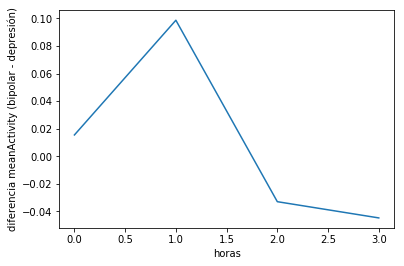

In [27]:
import matplotlib.pyplot as plt
plt.plot(range(0, n_hour_class), resul)
plt.ylabel('diferencia meanActivity (bipolar - depresión)')
plt.xlabel('horas')
plt.show()

Total días monitorizados por tipo paciente

In [28]:
print("Total días medidos", len(X_activity_final))
print("Total días medidos pacientes bipolares", len(X_activity_final[y_activity_final==1]))
print("Total días medidos pacientes depresión", len(X_activity_final[y_activity_final==2]))

Total días medidos 203
Total días medidos pacientes bipolares 103
Total días medidos pacientes depresión 100


Utilizamos diferentes algoritmos para medir la eficacia en la predicción de nuestros datos finales y realizar la elección del mejor modelo y sus parametros

In [29]:
mejorC = 0
mejorGamma = 0
maxPredictSVM = 0.0
for i in [1, 10, 100, 1000]:
    for j in [0.001]:
        model = SVC(kernel='rbf', C=i, gamma=j)
        scores = cross_val_score(model, X_activity_final, y_activity_final, cv=10, scoring='accuracy')
        if scores.mean() > maxPredictSVM:
            maxPredictSVM = scores.mean()
            mejorC = i
            mejorGamma = j
        print('C =', i, 'gamma =', j, ':', scores.mean())

C = 1 gamma = 0.001 : 0.5071428571428571
C = 10 gamma = 0.001 : 0.5021428571428571
C = 100 gamma = 0.001 : 0.5259523809523811
C = 1000 gamma = 0.001 : 0.6097619047619047


In [30]:
bestNumberOfEstimatorsRFC = 0
maxValueRFC = 0
for i in range(1, 101, 10):
    model = RandomForestClassifier(n_estimators=i)
    scores = cross_val_score(model, X_activity_final, y_activity_final, cv=10, scoring='accuracy')
    if scores.mean() > maxValueRFC:
        maxValueRFC = scores.mean()
        bestNumberOfEstimatorsRFC = i
    print('Numero estimadores' , i)
    print(scores.mean())

Numero estimadores 1
0.605
Numero estimadores 11
0.6557142857142857
Numero estimadores 21
0.6502380952380953
Numero estimadores 31
0.6297619047619046
Numero estimadores 41
0.6154761904761905
Numero estimadores 51
0.6404761904761905
Numero estimadores 61
0.6554761904761903
Numero estimadores 71
0.6254761904761905
Numero estimadores 81
0.6354761904761905
Numero estimadores 91
0.6745238095238095


In [30]:
bestNumberOfEstimatorsGBC = 0
maxValueGBC = 0.0
for i in range(1, 101, 10):
    model = GradientBoostingClassifier(random_state=1, n_estimators=i)
    scores = cross_val_score(model, X_activity_final, y_activity_final, cv=10, scoring='accuracy')
    if scores.mean() > maxValueGBC:
        maxValueGBC = scores.mean()
        bestNumberOfEstimatorsGBC = i
    print('Numero estimadores' , i)
    print(scores.mean())

Numero estimadores 1
0.5540909090909091
Numero estimadores 11
0.5981818181818181
Numero estimadores 21
0.6454545454545455
Numero estimadores 31
0.6304545454545455
Numero estimadores 41
0.6445454545454546
Numero estimadores 51
0.6490909090909092
Numero estimadores 61
0.6577272727272728
Numero estimadores 71
0.6577272727272727
Numero estimadores 81
0.6681818181818182
Numero estimadores 91
0.6631818181818183


In [31]:
bestNumNeuronas1 = 0
bestAlpha = 0
bestLearning_rate = 0
maxValueMLP = 0
for capa1 in range(10, 100, 10):
    for j in [0.1, 0.01, 0.001, 1,10,100]:
        ini = time.time()
        model = MLPClassifier(hidden_layer_sizes=[capa1], activation='relu',solver='lbfgs',alpha=j)
        scores = cross_val_score(model, X_activity_final, y_activity_final, cv=10, scoring='accuracy')
        fin = time.time()
        if scores.mean() > maxValueMLP:
            maxValueMLP = scores.mean()
            bestNumNeuronas1 = capa1
            bestAlpha = j
        print('Neuronas capa oculta: ',capa1,'alpha: ',j,':  ',scores.mean())
        print('Tiempo estimado:', fin-ini, 'segundos')

Neuronas capa oculta:  10 alpha:  0.1 :   0.6931818181818181
Tiempo estimado: 0.5195722579956055 segundos
Neuronas capa oculta:  10 alpha:  0.01 :   0.7018181818181818
Tiempo estimado: 0.5040197372436523 segundos
Neuronas capa oculta:  10 alpha:  0.001 :   0.6931818181818181
Tiempo estimado: 0.5262026786804199 segundos
Neuronas capa oculta:  10 alpha:  1 :   0.6790909090909091
Tiempo estimado: 0.46607065200805664 segundos
Neuronas capa oculta:  10 alpha:  10 :   0.615
Tiempo estimado: 0.21642231941223145 segundos
Neuronas capa oculta:  10 alpha:  100 :   0.5
Tiempo estimado: 0.05682706832885742 segundos
Neuronas capa oculta:  20 alpha:  0.1 :   0.7040909090909092
Tiempo estimado: 0.5834410190582275 segundos
Neuronas capa oculta:  20 alpha:  0.01 :   0.738181818181818
Tiempo estimado: 0.5868735313415527 segundos
Neuronas capa oculta:  20 alpha:  0.001 :   0.7081818181818182
Tiempo estimado: 0.6062180995941162 segundos
Neuronas capa oculta:  20 alpha:  1 :   0.7486363636363637
Tiempo est

Entrenamos los datos con el mejor modelo obtenido anteriormente

In [32]:
modelRandom = RandomForestClassifier(n_estimators=bestNumberOfEstimatorsRFC)
modelSVC = SVC(kernel='rbf', C=mejorC, gamma=mejorGamma)
modelGBC = GradientBoostingClassifier(random_state=1, n_estimators=bestNumberOfEstimatorsGBC)
modelMLP =  MLPClassifier(hidden_layer_sizes=[bestNumNeuronas1], activation='relu',solver='lbfgs',alpha=bestAlpha)
modelRandom.fit(X_activity_final, y_activity_final)
modelSVC.fit(X_activity_final, y_activity_final)
modelGBC.fit(X_activity_final, y_activity_final)
modelMLP.fit(X_activity_final, y_activity_final)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[30], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

Calculo de la matriz de decisión de los valores precision, recall y F1score

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_activity_final, y_activity_final, random_state=0)
class_names = ['bipolar', 'unipolar_depressive']

#y_pred = modelSVC.fit(X_train, y_train).predict(X_test)
#y_pred = modelRandom.fit(X_train, y_train).predict(X_test)
#y_pred = modelGBC.fit(X_train, y_train).predict(X_test)
y_pred = modelMLP.fit(X_train,y_train).predict(X_test)

precision, recall, f1Score, _ =precision_recall_fscore_support(y_test,y_pred)

def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print('Precision: ',precision)
print('Recall: ',recall)
print('F1 Score: ',f1Score)

NameError: name 'modelMLP' is not defined